![](header.jpg)

# Mahony Filter

Kevin J. Walchko, Phd

3 Jan 2021

---

## References

- [Madgwick, *An efficient orientation filter for inertial and inertial/magnetic sensor arrays*](madgwick.pdf)

## Quaternion Basics

Here we will use Hamiltonian (right-handed) quaternions throughout this work. The notation on the quaternion frames is $^{From}_{To}q$.

$$
^A_Cq = {}^B_Cq \otimes {}^A_Bq \\
^A_Bq = \begin{bmatrix} q_1 & q_2 & q_3 & q_4 \end{bmatrix} \\
^A_Bq^* = {}^B_Aq = \begin{bmatrix} q_1 & -q_2 & -q_3 & -q_4 \end{bmatrix} \\
^Bv = {}^A_Bq \otimes {}^Av \otimes {}^A_Bq^* 
$$

# Filter Equations

Madgwick did a great job designing this filter, but I find his paper hard to follow, especially with several typos in the mathematics. So I tried to boil it down to the useful equations.

![](imu.png)

## Definitions

| Symbol | Definition |
|---|:---|
| $S$ | Sensor Frame |
| $E$ | Earth Frame |
| $||x||$ | Norm of $x$ |
| $f_{g}$ | Objective function|
| $J_{g}$ | Jacobian of the objective funtion based on the gravity reference |
| $\nabla f$ | Gradient of the cost function which is composed of Jacobian and the objective function: $J^T_g f_g$ |
| $\omega_t$ | Raw gyro values |
| $\omega_b$ | Estimated gyro bias |
| $\omega_c$ | Converted gyro values free of biases |
| $a_t$ | accelerometer values |
| $\beta$ | Gain for filter or learning rate based on gradient feedback |
| $^S_Eq_t$ | Orientation at current time step |
| $^Eg$ | Gravitational reference, $\begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$ |


## Initialize

$$
^S_Eq_t = \begin{bmatrix} 1 & 0 & 0 & 0 \end{bmatrix} \\
^{S}\omega_{b,t} = \begin{bmatrix} 0 & 0 & 0 \end{bmatrix}^T
$$

## Loop

1. Get accelerometer ($^Sa_t$) and gyroscope ($^S\omega_t$) from the IMU
1. Normalize $^Sa_t$
1. Make sure the gyro is converted, if necessary, to rads/sec
1. Calculate time step $\Delta t$ from last sample time
1. Calculate the gradient $\nabla f$ and normalize to get $\frac{\nabla f}{|| \nabla f||}$, the formulation of $\Delta f$ is discussed below in the gradient section
1. Calculate the gyro bias:
    1. Estimate the error [47]: $^{S}\omega_{\epsilon,t} = 2^S_E\hat q^{*}_{est,t-1} \otimes \frac{\nabla f}{|| \nabla f||}$
    1. Integrate (discrete time) to get the current bias estimate [48]: $^{S}\omega_{b,t} = \zeta \sum ^{S}\omega_{\epsilon,t} \Delta t$
        1. $\zeta$ is the drift rate (rad/s/s) $\sqrt{\frac{3}{4}} \dot \omega_{\zeta}$
    1. Correct the raw gyro values [49]: $^{S}\omega_{c,t} = ^{S}\omega_{t} - ^{S}\omega_{b,t}$
1. Update orientation based on corrected gyros [12]: $^{S}_{E}\dot q_{\omega,t} = \frac{1}{2} ^{S}_{E}\hat q_{est,t-1} \otimes ^{S}\omega_{c,t}$
1. Correct the orientation rate using the estimated error [43]: $^{S}_{E}\dot q_{est,t} = ^{S}_{E}\dot q_{\omega,t} - \beta \frac{\nabla f}{|| \nabla f||}$
    1. Now $\beta$ is based on the error (rad/s) of  the gyro, you can use: $\sqrt{\frac{3}{4}} \omega_{\beta}$
1. Integrate (discrete time) the orientation rate to get the updated orientation [42]: $^{S}_{E}\hat q_{est,t} = ^{S}_{E}\hat q_{est,t-1} + ^{S}_{E}\dot q_{est,t} \Delta t$

## Gradient

For the imu filter, the gradient uses [21] and [22]. By substituting in values for gravity ($^Eg = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$) and the magnetic field reference, the equation simplify down to [25],[26]:

$$
\nabla f = J^T_g f_g\\
f_g(^{S}_{E}\hat q_{est,t-1}, a_t) = \begin{bmatrix}
    2(q_2q_4-q_1q_3)-a_x \\
    2(q_1q_2+q_3q_4)-a_y \\
    2(0.5-q_2^2-q_3^2)-a_z
\end{bmatrix} (eqn.25)\\
J_g(^{S}_{E}\hat q_{est,t-1}) = \begin{bmatrix}
    -2q_3 &  2q_4 & -2q_1 & 2q_2 \\
     2q_2 &  2q_1 &  2q_4 & 2q_3 \\
        0 & -4q_2 & -4q_3 &    0
\end{bmatrix} (eqn.26)\\
$$

# Get Data

In [8]:
import numpy as np # matrix manipulations
from numpy.linalg import norm

import the_collector # read data
print(f"the-collector: {the_collector.__version__}")

from the_collector import BagIt
from the_collector import Json, Pickle

from squaternion import Quaternion

import pandas as pd

from matplotlib import pyplot as plt 

from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

the-collector: 0.8.7


In [9]:
!ls -lh

total 49672
drwxr-xr-x  4 kevin  staff   128B Jan  3 10:27 archive
-rw-r--r--  1 kevin  staff    82K Jan  4 18:38 attitude-heading-reference-system-2.ipynb
-rw-r--r--  1 kevin  staff    75K Jan  3 22:28 attitude-heading-reference-system.ipynb
-rwx------  1 kevin  staff    11M Nov 23  2017 imu-1-2.json
-rwx------  1 kevin  staff    11M Apr 20  2020 imu-1-2.json-gz.bag
-rw-r--r--  1 kevin  staff   140K May  4  2019 imu-rpi.2019-05-04-20:47:18.445193.pickle.bag
-rw-r--r--@ 1 kevin  staff    82K Jan  3 21:57 imu.png
-rw-r--r--@ 1 kevin  staff   1.5M Jul 11  2017 madgwick.pdf
-rw-r--r--@ 1 kevin  staff    71K Oct 19 07:24 marg.png
-rw-r--r--@ 1 kevin  staff   554K Jan 27  2018 sensor_data.mp4


In [52]:
def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')

        
def get(data):
    ret = []
    ts = []
    for d,t in data:
        ret.append(d)
        ts.append(t)
    return np.array(ret), ts


if 0:
    bag = BagIt(Pickle)
    fname = "imu-rpi.2019-05-04-20:47:18.445193.pickle.bag"
    data = bag.read(fname)
else:
    bag = the_collector.BagIt(Json)
    bag.packer.compress(True)
    fname = "imu-1-2.json-gz.bag"
    data = bag.read(fname)

# print(f">> Bagit keys: {data.keys()}")
bag_info(data)

accel, stamp = get(data["accel"])
gyro, _ = get(data["gyro"])
# mag, stamp = get(data["mag"])

>> Reading[json-gz]: imu-1-2.json-gz.bag
Bag keys:
--------------------------------------------------
        gyro: 585    
      camera: 585    
       accel: 585    
         mag: 585    
     b64keys: 1      


# Run AHRS

Now the AHRS uses all of the sensors in the IMU. The code is shown below:

In [53]:
# this seems wrong, give different answer than Wikipedia
# also, his quaternions are different [c(t/2), -r*s(t/2), ...], why negative?
from math import atan2, asin, pi
def euler(q):
    q1,q2,q3,q4 = q
    r2d = 180/pi
    y = atan2(2*q2*q3-2*q1*q4,2*q1**2+2*q2**2-1) * r2d
    p = -asin(2*q2*q4+2*q1*q3) * r2d
    r = atan2(2*q3*q4-2*q1*q2,2*q1**2+2*q4**2-1) * r2d

    # adafruit
#     q0,q1,q2,q3 = q
#     r = atan2(q0 * q1 + q2 * q3, 0.5 - q1 * q1 - q2 * q2) * r2d
#     p = asin(-2.0 * (q1 * q3 - q0 * q2)) * r2d
#     y = atan2(q1 * q2 + q0 * q3, 0.5 - q2 * q2 - q3 * q3) * r2d
    return (r,p,y,)

In [76]:
class IMUFilter:
    """
    ref: Madgwick, An efficient orientation filter for inertial 
        and inertial/magnetic sensor arrays
    """
    def __init__(self, B, q=None):
        """
        q: [optional] initial quaternion, otherwise [1,0,0,0]
        B: Beta term in Madgwick's paper based on filter gradient learning 
        """
        self.wb = np.array([0,0,0])
        self.wcomp = True # estimate gyro bias
        self.wdr = 0.2 # gyro drift rate deg/sec/sec
        
        if q is None:
            self.q = Quaternion()
        else:
            self.q = q
            
        self.B = B

    def comp(self, del_f, dt):
        """
        Does the gyro compensation
        """
        q = self.q
        zeta = sqrt(3/4)*self.wdr*pi/180 # gyro drift: rad/s/s
        qwe = 2.0*q.conjugate*del_f # 47
        qwe = qwe.normalize
        self.wb = self.wb + zeta*np.array(qwe[1:])*dt # 48
        return self.wb

    def grad(self, a):
        """
        Calculates eqn #34, del_f/norm(del_f), which is the top
        block in the IMU flow diagram.
        """
        ax,ay,az = a
        q1,q2,q3,q4 = self.q

        fg = np.array([
            [2*(q2*q4-q1*q3)-ax],
            [2*(q1*q2+q3*q4)-ay],
            [2*(0.5-q2**2-q3**2)-az]
        ]) # 25
        Jg = np.array([
            [-2*q3,  2*q4, -2*q1, 2*q2],
            [ 2*q2,  2*q1,  2*q4, 2*q3],
            [    0, -4*q2, -4*q3,    0]
        ]) # 26, gradient of fg

        d = (Jg.T @ fg).T
        d = d.ravel()
        qq = Quaternion(*d).normalize 
        return qq.normalize

    def update(self, a, w, dt):
        """
        a: acceleration, term is normalize, so can be in any units
        w: gyro rates [rads/sec]
        dt: time step [sec]
        """
        a = a/norm(a)
        q = self.q
        del_f = self.grad(a) # gradient decent algorithm

        if self.wcomp:
            wb = self.comp(del_f,dt) # calculate bias
            w = w - wb               # 49
            
        qdw = 0.5*q*Quaternion(0,*w)
        qdot = qdw - self.B*del_f # filter
        q = q + qdot*dt           # integrate
        self.q = q.normalize
        return self.q

# Test

Ground truth:

- CW ~390, greater than 1 full rotation
- CCW ~410, back pass the starting point some
- Back to start + ~30, ended CW more than the starting point

In [80]:
# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"tt":[]}

start = stamp[0]
last = stamp[0]-0.1 # starting time stamp
tt = 0               # Test time
# q = Quaternion()
B = sqrt(3/4)*5*pi/180  # gyro measurement error rad/s
filt = IMUFilter(B)
filt.wcomp = False
wes = []

for a, g, ts in zip(accel, gyro, stamp):
    dt = ts - last # calculate time step
    
    q = filt.update(a,g*np.pi/180,dt)  # get orientation
    wes.append(filt.wb) # save gyro bias est for plotting
    r,p,y = q.to_euler(degrees=True)  # convert to euler
#     r,p,y = euler(q) # madgwick's appears wrong!
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    
    e["tt"].append(ts-start) # keep track of test time
    last = ts  # save previous time stamp

euler2 = pd.DataFrame(e)

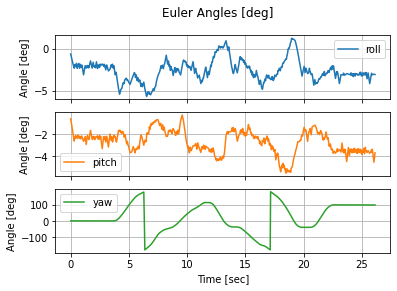

In [81]:
euler2.plot(
    x="tt", 
    subplots=True, grid=True, 
    title="Euler Angles [deg]",
    ylabel="Angle [deg]",
    xlabel="Time [sec]"
);

[0 0 0]


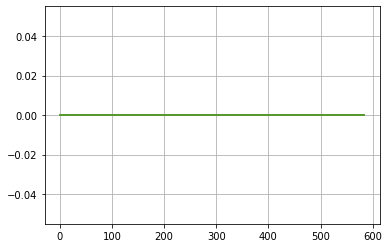

In [82]:
print(filt.wb)
plt.plot(wes)
plt.grid(True);